## Music Style Detector : CNN with Mel Spectogram

This notebook contains experimentation to create a music style detector by building a CNN model with Mel spectogram as input. The model is trained on a custom part of the FMA dataset and evaluated on the GTZAN dataset.

### 1. Imports and setup

In [37]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
import torchmetrics

from sklearn.model_selection import train_test_split
from datetime import datetime
import wandb
import matplotlib.pyplot as plt
import IPython.display as ipd
import numpy as np
import pandas as pd
import random
import os
import json

MODEL_DIR = os.path.abspath(os.path.join(os.getcwd(), '../..', 'models', 'genre_detector'))
DATA_DIR = os.path.join(MODEL_DIR, 'data')

### 2. Data pre-processing

In [38]:
class AudioUtil():
    """
    Utility class for audio processing.
    """
    @staticmethod
    def open(audio_file: str):
        """
        Load an audio file. Return the signal as a tensor and the sample rate.
        :param audio_file : Path to the audio file.
        :type audio_file : str
        :return: signal as a tensor and the sample rate
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = torchaudio.load(audio_file)
        return (signal, sample_rate)
    
    @staticmethod
    def rechannel(audio, new_channel):
        """
        Convert a given audio to the specified number of channels.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param new_channel: the target number of channels
        :type new_channel: int
        :return: the audio with the target number of channels
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio

        if (signal.shape[0] == new_channel):
            # nothing to do as the signal already has the target number of channels
            return audio
        if (new_channel == 1):
            # convert to mono by selecting only the first channel
            signal = signal[:1, :]
        else:
            # convert to stereo by duplicating the first channel
            signal = torch.cat([signal, signal])
        return (signal, sample_rate)
    
    @staticmethod
    def resample(audio, new_sample_rate):
        """
        Change the sample rate of the audio signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param new_sample_rate: the target sample rate
        :type new_sample_rate: int
        :return: the audio with the target sample rate
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        if (sample_rate == new_sample_rate):
            # nothing to do
            return audio
        resample = torchaudio.transforms.Resample(sample_rate, new_sample_rate)
        signal = resample(signal)
        return (signal, new_sample_rate)
    
    @staticmethod
    def pad_truncate(audio, length):
        """
        Pad or truncate an audio signal to a fixed length (in ms).
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param length: the target length in ms
        :type length: int
        :return: the audio with the target length
        :rtype: Tuple[torch.Tensor, int]
        """
        signal, sample_rate = audio
        max_length = sample_rate//1000 * length

        if (signal.shape[1] > max_length):
            signal = signal[:, :max_length]
        elif (signal.shape[1] < max_length):
            padding = max_length - signal.shape[1]
            signal = F.pad(signal, (0, padding))
        return (signal, sample_rate)
    
    @staticmethod
    def mel_spectrogram(audio, n_mels=64, n_fft=1024, hop_length=None):
        """
        Create the mel spectogram for the given audio signal.
        :param audio: the audio, composed of the signal and the sample rate
        :type audio: Tuple[torch.Tensor, int]
        :param n_mels: the number of mel filterbanks
        :type n_mels: int
        :param n_fft: the size of the FFT
        :type n_fft: int
        :param hop_length: the length of hop between STFT windows
        :type hop_length: int
        :return: the mel spectogram
        :rtype: torch.Tensor
        """
        signal, sample_rate = audio
        
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(
            sample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels
        )(signal)

        # convert to decibels
        mel_spectrogram = torchaudio.transforms.AmplitudeToDB()(mel_spectrogram)

        return mel_spectrogram

### 3. Training data loading

In [39]:
FMA_DIR = os.path.join(DATA_DIR, 'FMA')
GTZAN_DIR = os.path.join(DATA_DIR, 'GTZAN')
fma_df = pd.read_csv(os.path.join(FMA_DIR, 'fma_reduced_genres.csv'))
gtzan_df = pd.read_csv(os.path.join(GTZAN_DIR, 'gtzan_genres.csv'))
fma_df.head()

,filename,genre_label,genre_id
0,082066.mp3,Classical,1
1,065795.mp3,Classical,1
2,011721.mp3,Classical,1
3,145568.mp3,Classical,1
4,070936.mp3,Classical,1


In [40]:
# create a map of the genre_id to genre_label
id_to_label = fma_df.set_index('genre_id')['genre_label'].to_dict()
print(id_to_label)

{1: 'Classical', 4: 'Electronic', 5: 'Hip-Hop', 8: 'Pop', 10: 'Rock', 6: 'Jazz', 9: 'Reggae', 3: 'Disco', 0: 'Blues', 2: 'Country', 7: 'Metal'}


In [41]:
AUDIO_DURATION = 30000 # equals 30 seconds
SAMPLE_RATE = 44100
N_CHANNELS = 2
BATCH_SIZE = 32
NB_CLASSES = fma_df['genre_id'].nunique()
print(NB_CLASSES)

11


In [42]:
class GenreDataset(Dataset):
    """
    Dataset for the FMA dataset.
    """
    def __init__(self, df, audio_dir):
        """
        Constructor.
        :param df: the dataframe containing the audio files ids and their genre label
        :type df: pandas.DataFrame
        :param audio_dir: the directory containing the audio files
        :type audio_dir: str
        """
        self.fma_df = df
        self.audio_dir = audio_dir
        
    def __len__(self):
        """
        Get the length of the dataset.
        :return: the length of the dataset
        :rtype: int
        """
        return len(self.fma_df)
    
    def __getitem__(self, idx):
        """
        Get the idx-th sample of the dataset.
        :param idx: the index of the sample
        :type idx: int
        :return: the idx-th sample of the dataset and its genre label
        :rtype: Tuple[torch.Tensor, int]
        """ 
        audio_file_path = os.path.join(self.audio_dir, str(self.fma_df.iloc[idx]['filename']))
        # get the genre class id
        genre_id = self.fma_df.iloc[idx]['genre_id']

        # load the audio file and apply the preprocessing
        audio = AudioUtil.open(audio_file_path)
        audio = AudioUtil.rechannel(audio, N_CHANNELS)
        audio = AudioUtil.resample(audio, SAMPLE_RATE)
        audio = AudioUtil.pad_truncate(audio, AUDIO_DURATION)
        mel_spectrogram = AudioUtil.mel_spectrogram(audio)

        return (mel_spectrogram, genre_id)

64 2579


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

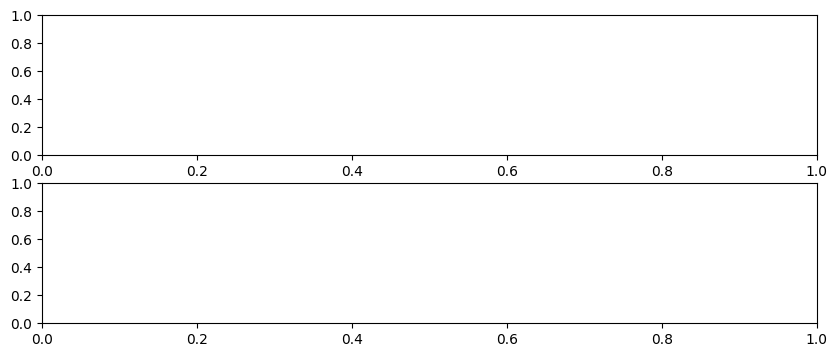

In [43]:
full_dataset = GenreDataset(fma_df, os.path.join(FMA_DIR, 'fma_reduced'))

# random split
nb_samples = len(full_dataset)
nb_train_samples = int(nb_samples * 0.8)
nb_val_samples = nb_samples - nb_train_samples
train_dataset, val_dataset = random_split(full_dataset, [nb_train_samples, nb_val_samples])

# create the data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,  num_workers=10)

# get first batch
batch = next(iter(train_loader))

mel_spectrogram = batch[0][0]
# print shape of the mel spectrogram
INPUT_HEIGHT = mel_spectrogram.shape[1]
INPUT_WIDTH = mel_spectrogram.shape[2]
print(INPUT_HEIGHT, INPUT_WIDTH)
# plot the spectrograms according to nb of channels
fig, axs = plt.subplots(N_CHANNELS, 1, figsize=(10, 4))
for c in range(N_CHANNELS):
    axs[c].imshow(mel_spectrogram[c,:,:].numpy(), cmap='hot')
    axs[c].set_title('Channel {}'.format(c+1))
    axs[c].set_xlabel('Time')
    axs[c].set_ylabel('Mel filterbank')
fig.suptitle('Mel spectrogram for the 2 channels')
plt.show()

print("Inputs shape: {}".format(mel_spectrogram.shape))

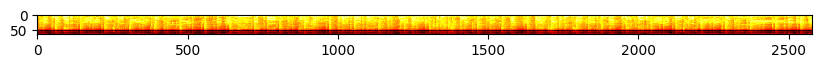

In [31]:
gtzan_dataset = GenreDataset(gtzan_df, os.path.join(GTZAN_DIR, 'genres_original_all'))

test_loader = DataLoader(gtzan_dataset, batch_size=BATCH_SIZE, shuffle=False)

# get first batch
batch = next(iter(test_loader))

mel_spectrogram = batch[0][0]
plt.figure(figsize=(10, 4))
plt.imshow(mel_spectrogram[0].numpy(), cmap='hot', interpolation='nearest')
plt.show()

### 4. Model creation

In [32]:
class AudioCNN(pl.LightningModule):
    """
    Audio classification model.
    """
    def __init__(self, nb_classes):
        """
        Constructor.
        :param nb_classes: the number of classes
        :type nb_classes: int
        """
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
        self.convnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 4))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        self.convnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 4))
        self.linear1 = nn.Linear(64*14*160, 256)
        self.linear1_bn = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(0.4)
        self.linear2 = nn.Linear(256, nb_classes)
        self.act = nn.LeakyReLU()

        self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=nb_classes)

    def forward(self, x):
        """
        Forward pass.
        :param x: the input
        :type x: torch.Tensor
        :return: the output
        :rtype: torch.Tensor
        """
        # Conv 1
        x = self.conv1(x)
        x = self.convnorm1(x)
        x = self.act(x)
        x = self.pool1(x) # output of shape (batch_size, 32, 31, 644)
        # Conv 2
        x = self.conv2(x) # output of shape (batch_size, 64, 29, 642)
        x = self.convnorm2(x)
        x = self.act(x)
        x = self.pool2(x) # output of shape (batch_size, 64, 14, 160)
        # Linear 1
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear1_bn(x)
        x = self.act(x)
        x = self.drop(x)
        # Linear 2
        x = self.linear2(x)
        return x
    
    def training_step(self, batch, batch_idx):
        """
        Training step.
        :param batch: the batch
        :type batch: Tuple[torch.Tensor, torch.Tensor]
        :param batch_idx: the batch index
        :type batch_idx: int
        :return: the loss
        :rtype: torch.Tensor
        """
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss)
        self.log('train_acc', self.accuracy(y_hat, y))
        return loss
    
    def validation_step(self, batch, batch_idx):
        """
        Validation step.
        :param batch: the batch
        :type batch: Tuple[torch.Tensor, torch.Tensor]
        :param batch_idx: the batch index
        :type batch_idx: int
        :return: the loss
        :rtype: torch.Tensor
        """
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', self.accuracy(y_hat, y))
        return loss
    
    def configure_optimizers(self):
        """
        Configure optimizers.
        :return: the optimizer
        :rtype: torch.optim.Optimizer
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def predict(self, x):
        """
        Predict.
        :param x: the input
        :type x: torch.Tensor
        :return: the prediction
        :rtype: torch.Tensor
        """
        y_hat = self.forward(x)
        return y_hat

### 5. Model training

In [33]:
torch.backends.cuda.matmul.allow_tf32 = True

In [36]:
model = AudioCNN(nb_classes=NB_CLASSES)
# Create the trainer
trainer = pl.Trainer(max_epochs=10)
# Fit the model
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name       | Type               | Params
---------------------------------------------------
0  | conv1      | Conv2d             | 608   
1  | convnorm1  | BatchNorm2d        | 64    
2  | pool1      | MaxPool2d          | 0     
3  | conv2      | Conv2d             | 18.5 K
4  | convnorm2  | BatchNorm2d        | 128   
5  | pool2      | MaxPool2d          | 0     
6  | linear1    | Linear             | 36.7 M
7  | linear1_bn | BatchNorm1d        | 512   
8  | drop       | Dropout            | 0     
9  | linear2    | Linear             | 2.8 K 
10 | act        | LeakyReLU          | 0     
11 | accuracy   | MulticlassAccuracy | 0     
---------------------------------------------------
36.7 M    Trainable params
0         Non-trainable params
36.7 M    Total params
146.892   Total estima

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/benjy/anaconda3/envs/pi_mlodimage/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [25]:
%tensorboard --logdir lightning_logs/

UsageError: Line magic function `%tensorboard` not found.


In [23]:
# get the last log
print(model.log)

<bound method LightningModule.log of AudioCNN(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (convnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (convnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=143360, out_features=256, bias=True)
  (linear1_bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.4, inplace=False)
  (linear2): Linear(in_features=256, out_features=11, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)>
